In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In this section, we perform template matching using `cv2.TM_CCOEFF_NORMED` for every video pair. We center crop corresponding frames to 3/4 * H, 3/4 * W. 

We store the correlation score for every frame pair.

In [ ]:
def perform_template_matching(template, target):
    result = cv2.matchTemplate(target, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    return max_val, max_loc

stable_path = 'E:/Datasets/DeepStab/stable/'
unstable_path = 'E:/Datasets/DeepStab/unstable/'
videos = os.listdir(stable_path)

# Initialize an empty DataFrame to store correlation scores
results_dict = {}

# Loop through each pair of videos
for video_name in videos:
    print(video_name)
    video_unstable_path = os.path.join(unstable_path, video_name)
    video_stable_path = os.path.join(stable_path, video_name)

    # Load video frames
    cap_unstable = cv2.VideoCapture(video_unstable_path)
    cap_stable = cv2.VideoCapture(video_stable_path)
    scores = []
    while True:
        ret_unstable, frame_unstable = cap_unstable.read()
        ret_stable, frame_stable = cap_stable.read()
        if not ret_stable or not ret_unstable:
            break
        # Center crop the unstable frame
        unstable_h, unstable_w = frame_unstable.shape[:2]
        crop_h, crop_w = int(0.75 * unstable_h), int(0.75 * unstable_w)
        y, x = (unstable_h - crop_h) // 2, (unstable_w - crop_w) // 2
        template = frame_unstable[y:y+crop_h, x:x+crop_w]

        # Perform template matching and store the correlation score
        correlation_score, max_loc = perform_template_matching(template, frame_stable)
        scores.append([correlation_score,max_loc])
    results_dict[video_name] = scores
    # Release video capture objects
    cap_unstable.release()
    cap_stable.release()


In [3]:
import pickle
# Save the dictionary to a file using pickle
with open('sequence_correlation_dict.pkl', 'wb') as file:
    pickle.dump(results_dict, file)

In [2]:
import pickle
with open('sequence_correlation_dict.pkl', 'rb') as file:
    results_dict = pickle.load(file)

In [3]:
results_dict

{'1.avi': [[0.7237151265144348, (41, 106)],
  [0.7491713762283325, (58, 93)],
  [0.7702827453613281, (80, 82)],
  [0.7893412709236145, (92, 73)],
  [0.7937291860580444, (107, 59)],
  [0.7904171347618103, (123, 52)],
  [0.8124216794967651, (158, 52)],
  [0.83835369348526, (190, 55)],
  [0.843453586101532, (196, 58)],
  [0.8486419916152954, (201, 61)],
  [0.8590496182441711, (212, 70)],
  [0.8446247577667236, (214, 82)],
  [0.8238353133201599, (205, 95)],
  [0.8225446343421936, (190, 105)],
  [0.8496741056442261, (177, 111)],
  [0.8856710195541382, (171, 113)],
  [0.8862769603729248, (168, 110)],
  [0.863945484161377, (164, 100)],
  [0.859786868095398, (157, 89)],
  [0.8697378039360046, (141, 79)],
  [0.881938099861145, (123, 72)],
  [0.890923798084259, (106, 68)],
  [0.8806184530258179, (86, 62)],
  [0.8796470165252686, (71, 51)],
  [0.886116087436676, (73, 40)],
  [0.8948391675949097, (88, 34)],
  [0.8922256231307983, (86, 28)],
  [0.8740200400352478, (77, 25)],
  [0.8579810857772827, 

**We find the mean correlation score over the whole dataset**

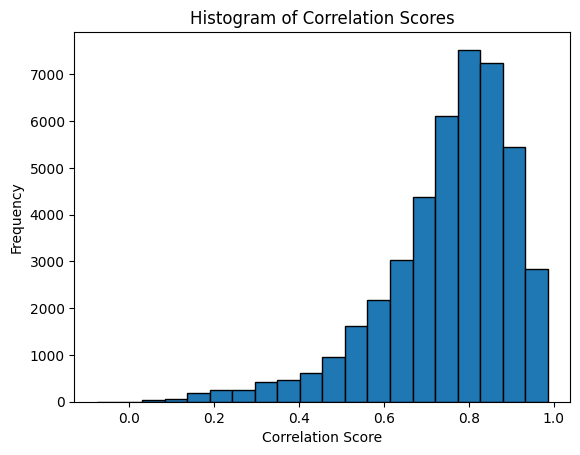

In [11]:
# Flatten the list of correlation scores
all_scores = []
for scores in results_dict.values():
    all_scores.extend(score[0] for score in scores)

# Plot the histogram
plt.hist(all_scores, bins=20, edgecolor='black')
plt.xlabel('Correlation Score')
plt.ylabel('Frequency')
plt.title('Histogram of Correlation Scores')
plt.show()

In [12]:
# Calculate the mean and standard deviation
mean_score = np.mean(all_scores)
std_score = np.std(all_scores)

# Display the results
print(f"Mean of correlation scores: {mean_score:.3f}")
print(f"Standard Deviation of correlation scores: {std_score:.3f}")

Mean of correlation scores: 0.751
Standard Deviation of correlation scores: 0.154


In [6]:
stable_path = 'E:/Datasets/DeepStab/stable/'
unstable_path = 'E:/Datasets/DeepStab/unstable/'
videos = os.listdir(stable_path)

**We will make a video pair out of every frame sequence that is longer than 100 frames with 
a correlation score larger than the mean. We store the start and end frame indexes 
for every such sequence in 'sequences_dict'**

In [7]:
sequences_dict = {}
for video in videos:
    start_idx = None
    end_idx = None
    scores = [item[0] for item in results_dict[video]]
    positions = [item[1] for item in results_dict[video]]
    sequences = []
    for idx,score in enumerate(scores):
        #start counting
        if score >= 0.751 and start_idx == None:
            start_idx = idx
            end_idx = idx
        elif score >= 0.751 and start_idx != None:
            end_idx = idx
        elif score < 0.751 and start_idx != None: # which means sequence was counting and just ended
            if end_idx - start_idx >= 100:
                sequences.append((start_idx, end_idx))
            start_idx = None
            end_idx = None
    pos = []
    for seq in sequences:
        pos.append(positions[seq[0]:seq[1] + 1])
    sequences_dict[video] = sequences , pos

**For example video '48.avi' has only two sequences that satisfy the conditions,
from frames 21 --> 210 and 222 --> 343**

In [14]:
sequences, _ = sequences_dict['48.avi']
sequences

[(21, 210), (222, 343)]

In [16]:
with open('valid_sequences_dict.pkl', 'wb') as file:
    pickle.dump(sequences_dict, file)

**Here we create the new dataset consisting only of sequences with small perspective mismatch**

In [15]:
vstable_path = 'E:/Datasets/DeepStab/stable/'
unstable_path = 'E:/Datasets/DeepStab/unstable/'
dst_stable_path = 'E:/Datasets/Deepstab cropped2/stable/'
dst_unstable_path = 'E:/Datasets/Deepstab cropped2/unstable/'
h,w = 720, 1280
th, tw = int(0.75 * h), int(0.75 * w)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
videos = os.listdir(stable_path)
video_idx = 1
videos = os.listdir(stable_path)
for video_name in videos:
    print(video_name)
    sequences, pos = sequences_dict[video_name]
    for i, seq in enumerate(sequences):
        s_cap = cv2.VideoCapture(stable_path + video_name)
        u_cap = cv2.VideoCapture(unstable_path + video_name)
        start_idx, end_idx = seq 
        s_cap.set(cv2.CAP_PROP_POS_FRAMES, start_idx)
        u_cap.set(cv2.CAP_PROP_POS_FRAMES, start_idx)
        s_out = cv2.VideoWriter(dst_stable_path + f'{video_idx}.avi', fourcc, 30.0, (tw, th))
        u_out = cv2.VideoWriter(dst_unstable_path + f'{video_idx}.avi', fourcc, 30.0, (tw, th))
        video_idx += 1
        for el,frame_idx in enumerate(range(start_idx,end_idx+1)):
            ret1,stable_frame = s_cap.read()
            ret2,unstable_frame = u_cap.read()
            if not ret1 or not ret2:
                print(video_name,frame_idx, 'broken')
                break
            x = pos[i][el][0]
            y = pos[i][el][1]
            stable_cropped = stable_frame[y: y+th, x: x+tw, :]
            unstable_cropped = unstable_frame[y: y+th, x: x+tw, :]
            s_out.write(stable_cropped)
            u_out.write(unstable_cropped)
        s_cap.release()
        u_cap.release()
        s_out.release()
        u_out.release()

1.avi
10.avi
11.avi
12.avi
13.avi
14.avi
15.avi
16.avi
17.avi
18.avi
19.avi
2.avi
20.avi
21.avi
22.avi
23.avi
24.avi
25.avi
26.avi
27.avi
28.avi
29.avi
3.avi
30.avi
31.avi
32.avi
33.avi
34.avi
35.avi
36.avi
37.avi
38.avi
39.avi
4.avi
40.avi
41.avi
42.avi
43.avi
44.avi
45.avi
46.avi
47.avi
48.avi
49.avi
5.avi
50.avi
51.avi
52.avi
53.avi
54.avi
55.avi
56.avi
57.avi
58.avi
59.avi
6.avi
60.avi
61.avi
7.avi
8.avi
9.avi


In [ ]:
s_cap = cv2.VideoCapture(stable_path+'1.avi')

In [ ]:
s_cap.set(cv2.CAP_PROP_FR)